In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 物理定数(cgs)
au = 1.49597877e13 # au[cm]
Msun = 1.9884e33 # 太陽質量[g]
Rsun = 6.96e10 # 太陽半径[cm]
G = 6.67430e-8 # 万有引力定数[cgs]
c = 2.99792458e10 # 光速度[cm/s]
M_J = 1.898e30 # 木星質量[g]
R_J = 6.9911e9 # 木星半径[cm]
day = 60*60*24 # 1日[s]
hr = 60*60 # 1時間[s]
M_e = 5.972e27 # 地球質量[g]
R_e = 6.378e6 # 地球半径[cm]

# 設定(a)

$e=0$を仮定する(真円)

In [78]:
R_star = Rsun # 恒星半径
M_star = Msun # 恒星質量
M_p = 13*M_J # 惑星質量
R_p = R_J # 惑星半径
a = 3*au # 公転半径
P = 2*np.pi*(a**3/(G*(M_star+M_p)))**0.5 # ケプラー真円の周期
omega = 2*np.pi / P # 角速度

遮蔽による減光と重力レンズによる増光を別々に見積もって最終的に合算する.

まずは増光.

時刻$t$の原点は地球,惑星,恒星がこの順に視線上に並ぶ時刻とする.

ケプラー円運動より惑星の位置は$a\sin(\omega t)$だが, トランジットする時刻付近だけ考えればよく, その時間は周期に対し十分短いので
\begin{align} 
 a\sin(\omega t)\simeq a\omega t
\end{align}
これを$D_L$で割った$\beta$が天球面上での位置で, 増光率はこれを用いて表される.
\begin{align}
 \mu=\frac{u^2+2}{u\sqrt{u^2+4}},\quad u=\frac{\beta}{\theta_E}
\end{align}

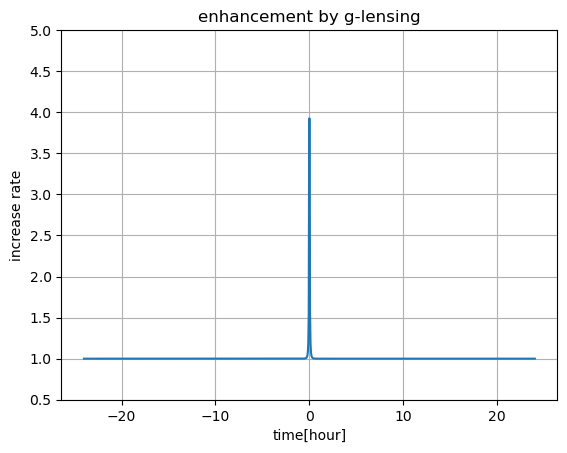

In [79]:
# 距離の設定
D_S = 1000*au # ソース天体(恒星)までの距離(Ds>>aであればなんでも良い)
D_L = D_S - a  # レンズ天体(惑星)までの距離
D_LS = a   # レンズ天体とソース天体の距離差

theta_E = (4*G*M_p*D_LS/(c**2*D_L*D_S))**0.5 # アインシュタイン半径


t = np.linspace(-day,day, 1000) # 時刻[s]
beta = a*omega*t / D_L # 惑星の位置(角度)
beta_abs = np.abs(beta) # 惑星の中心からの距離(角度)

# 増光率の計算
u = beta_abs / theta_E
mu = (u**2 + 2) / (u*(u**2 + 4)**0.5)


# プロット
plt.figure()
plt.plot(t / hr, mu)
plt.ylim(0.5,5)
plt.xlabel("time[hour]")
plt.ylabel("increase rate")
plt.title("enhancement by g-lensing")
plt.grid()
plt.savefig('g-lensing.pdf')

次に減光率を見積もる. 
恒星のうち, 惑星と被って遮蔽される割合を計算すれば良い.
これは解析的に積分可能である.

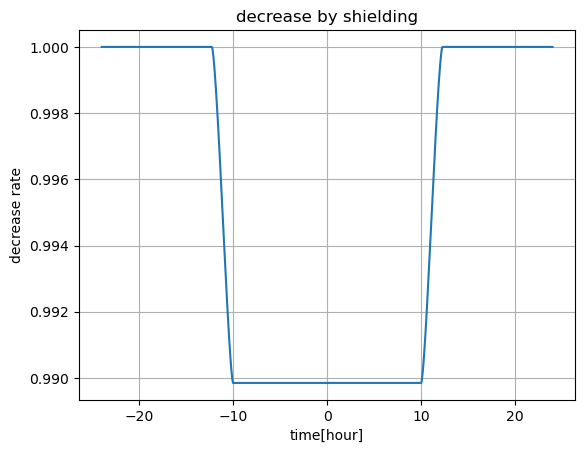

In [80]:
# 単位円の積分を定義
def circle_intergration(a,b):
    theta_a = np.arccos(a)
    theta_b = np.arccos(b)
    I = (theta_a-theta_b) - (np.sin(2*theta_a) - np.sin(2*theta_b)) / 2
    return I

# 減光率の計算
d = np.zeros_like(t)
for i in range(len(t)):
    time = t[i]
    x_p = np.abs(a*omega*time) # 時刻tでの, 恒星中心からの惑星の距離
    beta = x_p / D_L # 恒星中心からの惑星の距離(角度)
    theta_S = R_star / D_S
    theta_p = R_p / D_L

    if beta <= theta_S - theta_p:  # 完全に被る場合
        d[i] = theta_p**2 / theta_S**2
    elif beta >= theta_S + theta_p: # 被らない場合
        d[i] = 0
    else : # 部分的に被る場合
        phase1 = (theta_S**2-theta_p**2-beta**2) / (2*beta*theta_p)
        phase2 = (theta_S**2-theta_p**2+beta**2) / (2*beta*theta_S)
        S = theta_p**2*circle_intergration(-1, phase1) + theta_S**2*circle_intergration(phase2,1)
        d[i] = S / (np.pi*theta_S**2)


# プロット
plt.figure()
plt.plot(t / hr, 1-d)
plt.xlabel("time[hour]")
plt.ylabel("decrease rate")
plt.title("decrease by shielding")
plt.grid()
plt.savefig('shielding.pdf')

合計

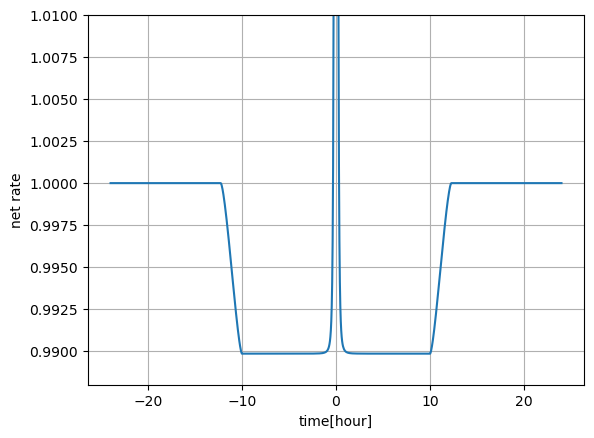

In [81]:
# 減光と増光の和
plt.plot(t/ 3600, mu-d)
plt.ylim(0.988,1.01)
plt.xlabel("time[hour]")
plt.ylabel("net rate")
plt.grid()
plt.savefig('transit_lightcurve_pointsource.pdf')

明らかにこれは物理的ではないのでこれではいけない. これは増光率の式が$u\rightarrow0$の(惑星が恒星中心に位置する)ときに発散することに由来する.
原因は増光率の式が点源からの光に対して適用されることにある.

# 設定(a) (有限ソース天体)

そこで, 増光率の公式を恒星の面要素$dxdy$に適用し, 面積積分することで"平均の"増光率を見積もることを考える.
\begin{align}
  \mu =\frac{1}{A}\int_D \frac{u^2+2}{u\sqrt{u^2+4}}dxdy
\end{align}

ここで$D$を, 恒星のうち惑星によって遮蔽されない部分
\begin{align}
 D=\{(x,y)|x^2+y^2<\theta_S^2, (x-\beta)^2+y^2>\theta_p^2\},\quad (\theta_S,\theta_p)=(R_\star/D_S, R_p/D_L)
\end{align}
とすれば自然に遮蔽による減光も取り入れることができる. 

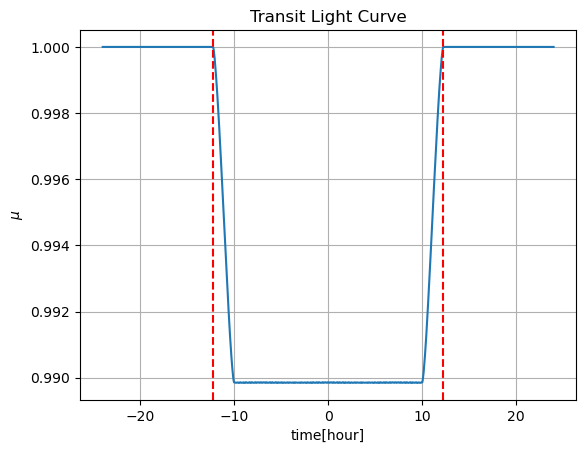

In [75]:
# 改めて設定
R_star = Rsun
M_star = Msun
M_p = 13 * M_J
R_p = R_J
a = 3 * au
D_S = 1000 * au # 恒星までの距離(なんでも良い)
D_L = D_S - a # 惑星までの距離(Lはレンズの意)
D_LS = a
theta_E = np.sqrt(4 * G * M_p * D_LS / (c**2 * D_L * D_S)) # アインシュタイン半径
 
P = 2 * np.pi * np.sqrt(a**3 / (G * (M_star + M_p))) # ケプラー運動の周期
omega = 2 * np.pi / P # 角速度

theta_S = R_star / D_S # 恒星の半径(角度)
theta_p = R_p / D_L # 惑星の半径(角度)


# 積分の準備(グリッドの設置)
N = 1000 
xgrid = np.linspace(-theta_S, theta_S, N)
ygrid = np.linspace(-theta_S, theta_S, N)
dx = xgrid[1] - xgrid[0]
dy = ygrid[1] - ygrid[0]
X, Y = np.meshgrid(xgrid, ygrid)
R2 = X**2 + Y**2 

# 恒星のディスク内
in_star = R2 < theta_S**2

mu = np.zeros_like(t) # 初期化

# 面積積分
def area_integration(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    A = dx * dy

    A_total = A * np.sum(in_star) # 恒星の面積
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率


# 全tに対して計算 
for i in range(len(t)):
    time = t[i]
    beta_t = a * omega * time / D_L  # 惑星の位置（角度）
    mu[i] = area_integration(beta_t)

t_edge = (D_L / (a * omega)) * (theta_S + theta_p)  # トランジット開始,終了時刻

# プロット
plt.plot(t / hr, mu)
plt.axvline(x= t_edge / hr, color='red', linestyle='--', label='Transit Edge')
plt.axvline(x=-t_edge / hr, color='red', linestyle='--')
plt.xlabel("time[hour]")
plt.ylabel(r"$\mu$")
plt.title("Transit Light Curve")
plt.grid()
plt.savefig('transit_lightcurve_a.pdf')

妥当そうな計算結果になっている

# 周縁減光の効果

In [ ]:
mu_0 = np.zeros_like(t) # 初期化
mu_1 = np.zeros_like(t) # 初期化
mu_2 = np.zeros_like(t) # 初期化

# 周縁減光なし
def area_integration_0(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    A = dx * dy

    A_total = A * np.sum(in_star) # 恒星の面積
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率



# 線形の周縁減光
def area_integration_1(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet


    A = dx * dy

    # 全体のエネルギー見積もり
    theta = np.sqrt(X**2 + Y**2)
    eta = np.sqrt(1-(theta*D_S/R_star)**2) 
    L = 1-0.4*(1-eta) # Limb darkning 
    A_total = A * np.sum(L[in_star]) # 恒星の面積

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    L_mask = L[mask]

    
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) * L_mask # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率



# 2次の周縁減光
def area_integration_2(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet


    A = dx * dy

    # 全体の輻射強度の見積もり
    theta = np.sqrt(X**2 + Y**2)
    eta = np.sqrt(1-(theta*D_S/R_star)**2) 
    L = 1-0.4*(1-eta)-0.3*(1-eta)**2 # Limb darkning 
    A_total = A * np.sum(L[in_star]) # 恒星の面積

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    L_mask = L[mask]

    
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) * L_mask # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率


for i in range(len(t)):
    time = t[i]
    beta_t = a * omega * time / D_L  # 惑星の位置（角度）
    mu_0[i] = area_integration_0(beta_t)
    mu_1[i] = area_integration_1(beta_t)
    mu_2[i] = area_integration_2(beta_t)

t_edge = (D_L / (a * omega)) * (theta_S + theta_p)  # トランジット開始,終了時刻


/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_88686/3791923511.py:40: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1-(theta*D_S/R_star)**2)
/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_88686/3791923511.py:70: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1-(theta*D_S/R_star)**2)


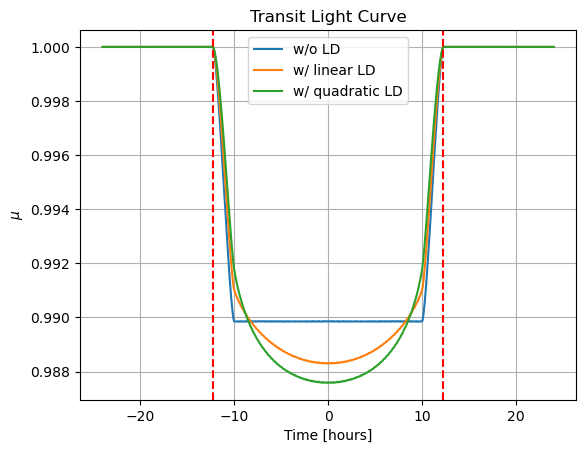

In [86]:
# プロット
plt.plot(t / 3600, mu_0, label='w/o LD')
plt.plot(t / 3600, mu_1, label='w/ linear LD')
plt.plot(t / 3600, mu_2, label= 'w/ quadratic LD')
plt.axvline(x= t_edge / 3600, color='red', linestyle='--')
plt.axvline(x=-t_edge / 3600, color='red', linestyle='--')
plt.xlabel("Time [hours]")
plt.ylabel(r"$\mu$")
plt.title("Transit Light Curve")
plt.legend()
plt.grid()

plt.savefig('transit_lightcurve_LD_a.pdf')

# 設定(b) (有限ソース天体)

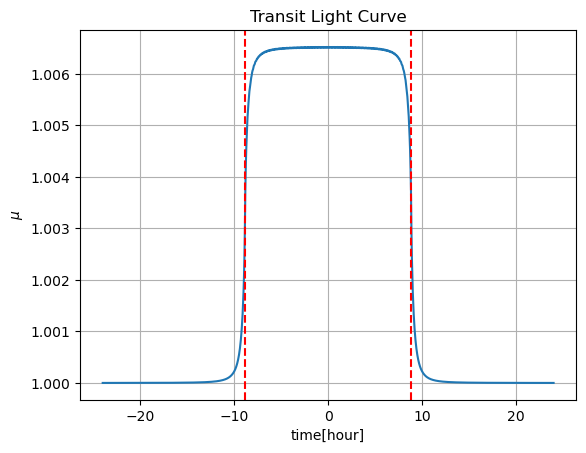

In [87]:
# 設定
R_star = Rsun
M_star = Msun
M_p = 0.6 * Msun
R_p = R_e

a = 3 * au
D_S = 1000 * au # 恒星までの距離(なんでも良い)
D_L = D_S - a # 惑星までの距離(Lはレンズの意)
D_LS = a
theta_E = np.sqrt(4 * G * M_p * D_LS / (c**2 * D_L * D_S)) # アインシュタイン半径
 
P = 2 * np.pi * np.sqrt(a**3 / (G * (M_star + M_p))) # ケプラー運動の周期
omega = 2 * np.pi / P # 角速度

theta_S = R_star / D_S # 恒星の半径(角度)
theta_p = R_p / D_L # 惑星の半径(角度)


# 積分の準備(グリッドの設置)
N = 1000 
xgrid = np.linspace(-theta_S, theta_S, N)
ygrid = np.linspace(-theta_S, theta_S, N)
dx = xgrid[1] - xgrid[0]
dy = ygrid[1] - ygrid[0]
X, Y = np.meshgrid(xgrid, ygrid)
R2 = X**2 + Y**2 

# 恒星のディスク内
in_star = R2 < theta_S**2

mu = np.zeros_like(t) # 初期化

# 面積積分
def area_integration(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    A = dx * dy

    A_total = A * np.sum(in_star) # 恒星の面積
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率


# 全tに対して計算 
for i in range(len(t)):
    time = t[i]
    beta_t = a * omega * time / D_L  # 惑星の位置（角度）
    mu[i] = area_integration(beta_t)

t_edge = (D_L / (a * omega)) * (theta_S + theta_p)  # トランジット開始,終了時刻

# プロット
plt.plot(t / hr, mu)
plt.axvline(x= t_edge / hr, color='red', linestyle='--', label='Transit Edge')
plt.axvline(x=-t_edge / hr, color='red', linestyle='--')
plt.xlabel("time[hour]")
plt.ylabel(r"$\mu$")
plt.title("Transit Light Curve")
plt.grid()
plt.savefig('transit_lightcurve_b.pdf')

In [88]:
mu_0 = np.zeros_like(t) # 初期化
mu_1 = np.zeros_like(t) # 初期化
mu_2 = np.zeros_like(t) # 初期化

# 周縁減光なし
def area_integration_0(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    A = dx * dy

    A_total = A * np.sum(in_star) # 恒星の面積
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率



# 線形の周縁減光
def area_integration_1(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet


    A = dx * dy

    # 全体のエネルギー見積もり
    theta = np.sqrt(X**2 + Y**2)
    eta = np.sqrt(1-(theta*D_S/R_star)**2) 
    L = 1-0.4*(1-eta) # Limb darkning 
    A_total = A * np.sum(L[in_star]) # 恒星の面積

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    L_mask = L[mask]

    
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) * L_mask # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率



# 2次の周縁減光
def area_integration_2(beta_t):
    # 惑星の遮蔽円マスク
    R2_p = (X - beta_t)**2 + Y**2
    not_in_planet = R2_p > theta_p**2

    # 積分対象領域 = 恒星ディスク内 かつ 惑星で遮られてない
    mask = in_star & not_in_planet


    A = dx * dy

    # 全体のエネルギー見積もり
    theta = np.sqrt(X**2 + Y**2)
    eta = np.sqrt(1-(theta*D_S/R_star)**2) 
    L = 1-0.4*(1-eta)-0.3*(1-eta)**2 # Limb darkning 
    A_total = A * np.sum(L[in_star]) # 恒星の面積

    r = np.sqrt((X - beta_t)**2 + Y**2)[mask]
    u = r / theta_E
    L_mask = L[mask]

    
    mu_local = (u**2 + 2) / (u * np.sqrt(u**2 + 4)) * L_mask # 局所増光率
    I = A * np.sum(mu_local) # 積分

    return I / A_total # 増光率


for i in range(len(t)):
    time = t[i]
    beta_t = a * omega * time / D_L  # 惑星の位置（角度）
    mu_0[i] = area_integration_0(beta_t)
    mu_1[i] = area_integration_1(beta_t)
    mu_2[i] = area_integration_2(beta_t)

t_edge = (D_L / (a * omega)) * (theta_S + theta_p)  # トランジット開始,終了時刻


/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_88686/3791923511.py:40: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1-(theta*D_S/R_star)**2)
/var/folders/pv/68c56c_d7_3gzv7n8wjb5q1c0000gn/T/ipykernel_88686/3791923511.py:70: RuntimeWarning: invalid value encountered in sqrt
  eta = np.sqrt(1-(theta*D_S/R_star)**2)


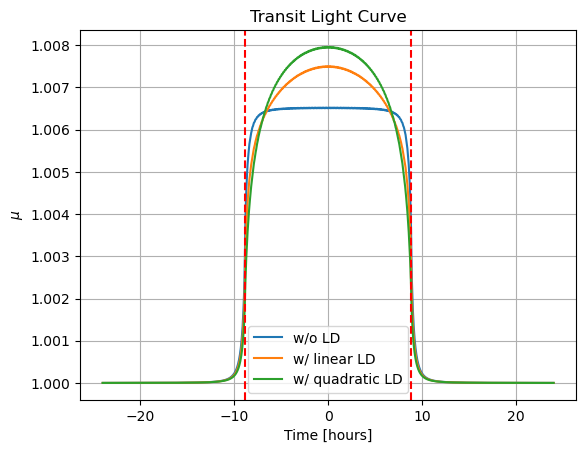

In [90]:
# プロット
plt.plot(t / 3600, mu_0, label='w/o LD')
plt.plot(t / 3600, mu_1, label='w/ linear LD')
plt.plot(t / 3600, mu_2, label= 'w/ quadratic LD')
plt.axvline(x= t_edge / 3600, color='red', linestyle='--')
plt.axvline(x=-t_edge / 3600, color='red', linestyle='--')
plt.xlabel("Time [hours]")
plt.ylabel(r"$\mu$")
plt.title("Transit Light Curve")
plt.legend()
plt.grid()

plt.savefig('transit_lightcurve_LD_b.pdf')